In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import sklearn.linear_model
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose


In [8]:
raw_df = pd.read_csv("data/May2018-May2019.csv")
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 644496 Airbnb listings


,date,id,host_id,neighbourhood,room_type,price,minimum_nights,calculated_host_listings_count
0,5/9/18,2515,2758,Harlem,Private room,59.0,2,3
1,5/9/18,2539,2787,Kensington,Private room,79.0,1,7
2,5/9/18,2595,2845,Midtown,Entire home/apt,225.0,1,2


In [25]:
raw_df.date = pd.to_datetime(raw_df.date) 


In [26]:
raw_df.isna().sum()


date                              0
id                                0
host_id                           0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
dtype: int64

In [27]:
raw_df.price.value_counts()

150.0     26871
100.0     26030
50.0      20629
60.0      19340
200.0     18524
          ...  
891.0         1
2549.0        1
3598.0        1
901.0         1
817.0         1
Name: price, Length: 997, dtype: int64

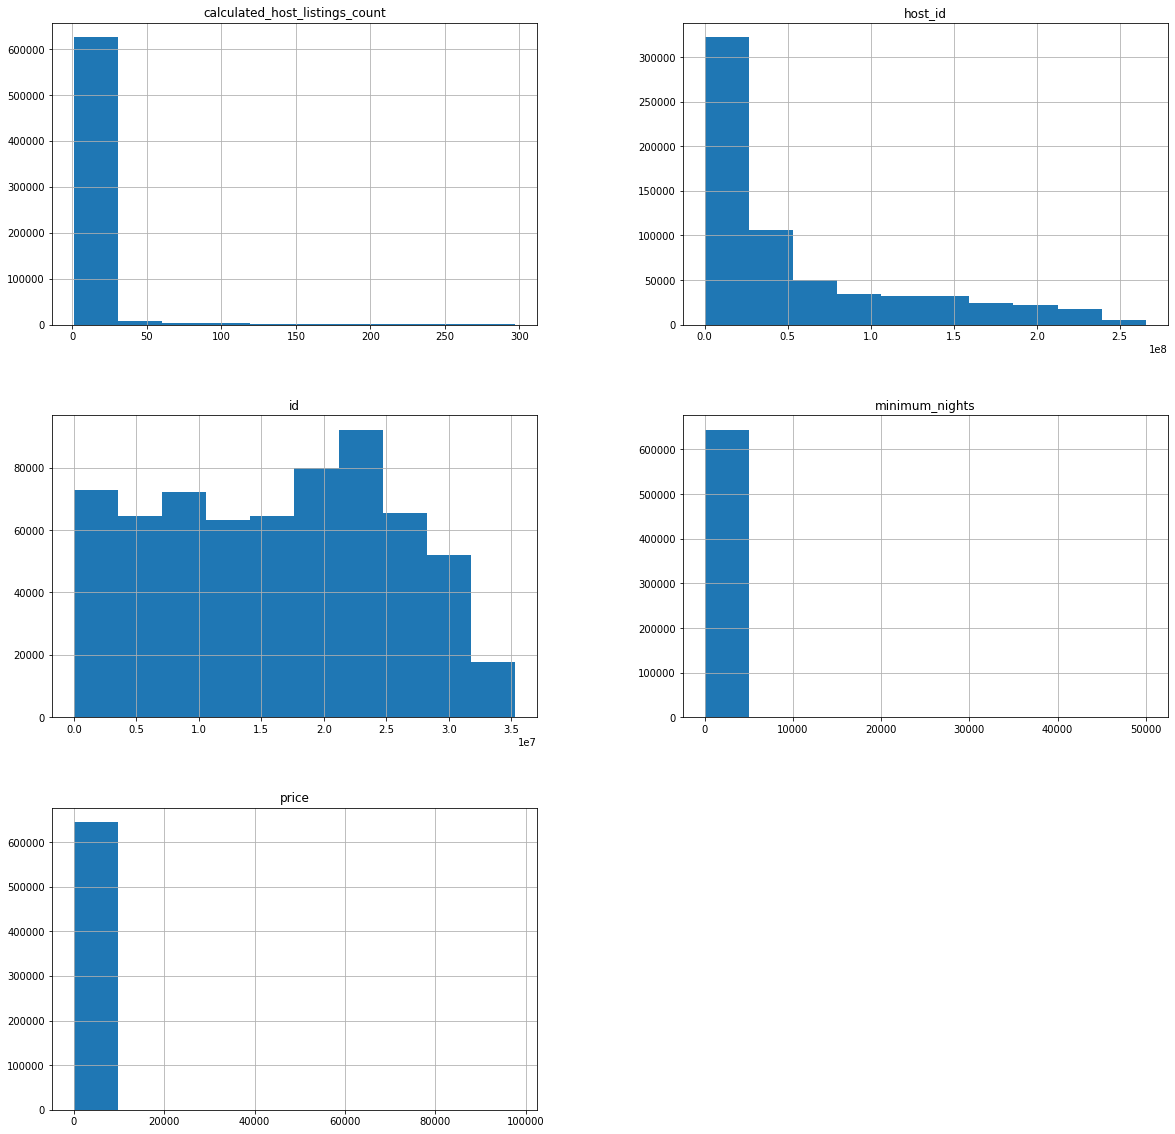

In [28]:
# Replacing columns with f/t with 0/1
raw_df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
raw_df.hist(figsize=(20,20));

In [29]:
raw_df.room_type.value_counts()


Entire home/apt    335277
Private room       294527
Shared room         14692
Name: room_type, dtype: int64

In [30]:
print("Mean nightly price of listings in each year on Airbnb in NYC:")
print(round(raw_df.set_index('date').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in NYC:
date
2018-01-01    150.10
2019-01-01    152.02
Freq: AS-JAN, Name: price, dtype: float64


In [33]:
host_listings_count = raw_df.host_id.value_counts()
host_listings_count

107434423    1595
30283594     1471
22541573     1067
16098958     1032
219517861     964
             ... 
79653673        1
27335399        1
2599473         1
228024872       1
17913899        1
Name: host_id, Length: 59282, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


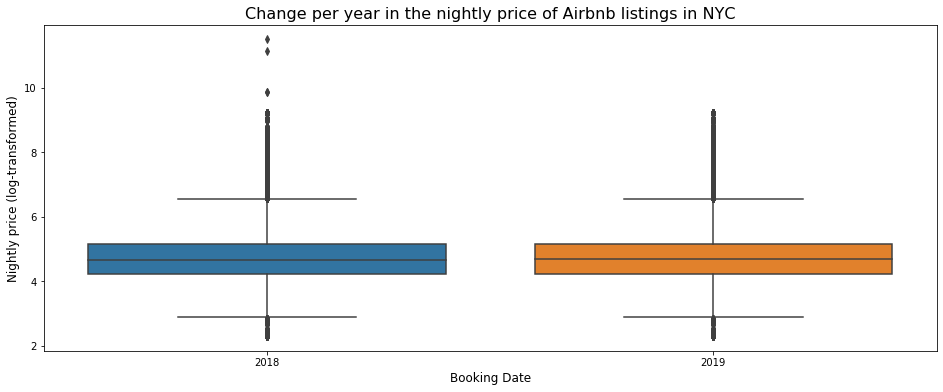

In [37]:
plt.figure(figsize=(16,6))
sns.boxplot(raw_df.date.dt.year, np.log(raw_df.price))
plt.xlabel('Booking Date', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in NYC', fontsize=16)
plt.show()

In [38]:
raw_df.describe()

,id,host_id,price,minimum_nights,calculated_host_listings_count
count,6.444960e+05,6.444960e+05,644496.000000,644496.000000,644496.000000
mean,1.620088e+07,5.550720e+07,150.837322,6.817555,4.502957
std,9.270845e+06,6.421395e+07,270.246080,125.969881,17.532499
min,2.454000e+03,2.830000e+02,0.000000,1.000000,1.000000
25%,8.303337e+06,7.040483e+06,69.000000,1.000000,1.000000
50%,1.667857e+07,2.655670e+07,105.000000,2.000000,1.000000
75%,2.346603e+07,8.375453e+07,175.000000,5.000000,2.000000
max,3.530389e+07,2.657038e+08,97598.000000,50000.000000,297.000000


In [39]:
print(f"Nightly advertised prices range from ${min(raw_df.price)} to ${max(raw_df.price)}.")


Nightly advertised prices range from $0.0 to $97598.0.


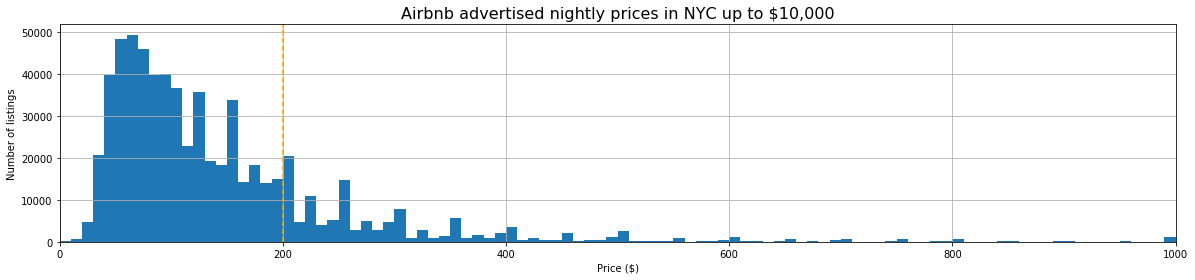

In [40]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in NYC up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

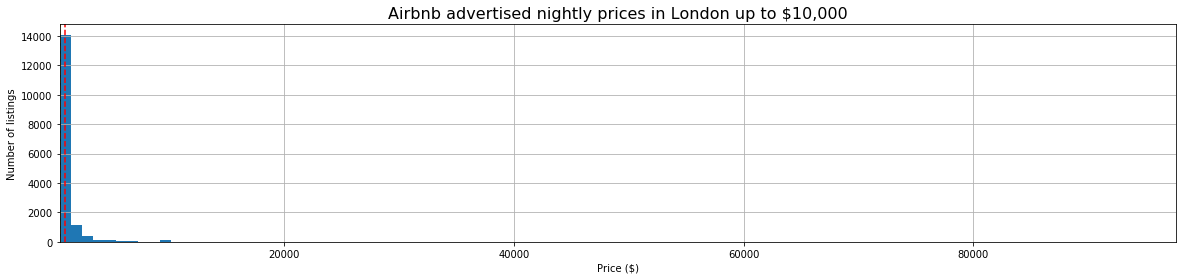

In [42]:
# Distribution of prices from $500 upwards
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(500, max(raw_df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in London up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [45]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    raw_df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

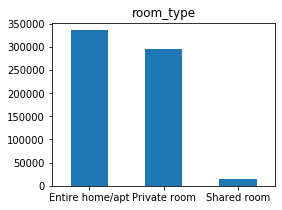

Entire home/apt    0.520216
Private room       0.456988
Shared room        0.022796
Name: room_type, dtype: float64


In [47]:
for col in ['room_type']:
    category_count_plot(col, figsize=(4,3))
    print(raw_df[col].value_counts(normalize=True))

In [48]:
transformed_df = pd.get_dummies(raw_df)

In [49]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

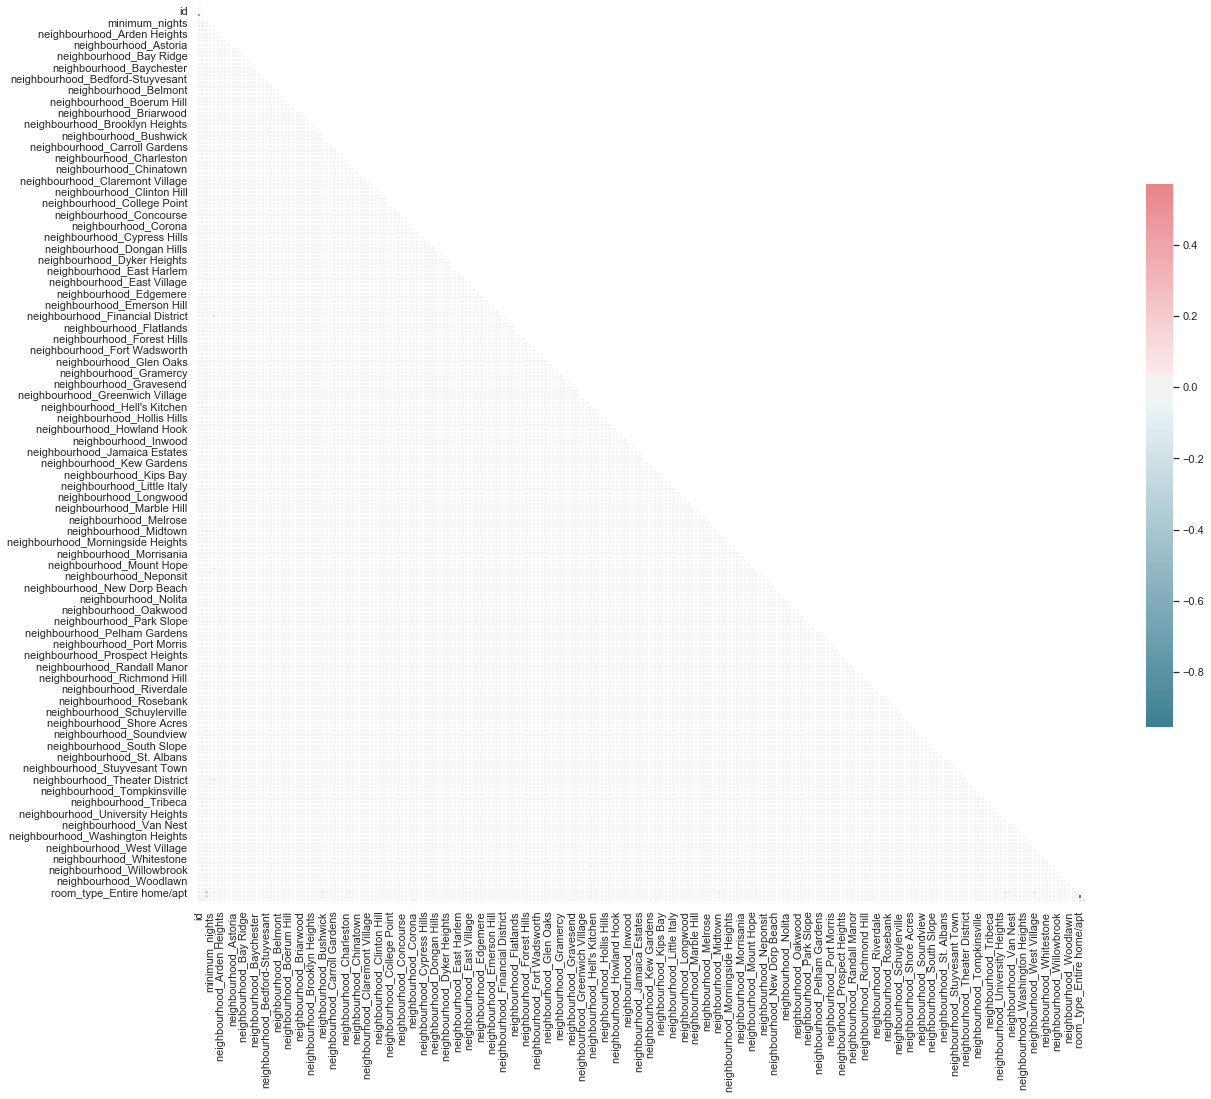

In [50]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

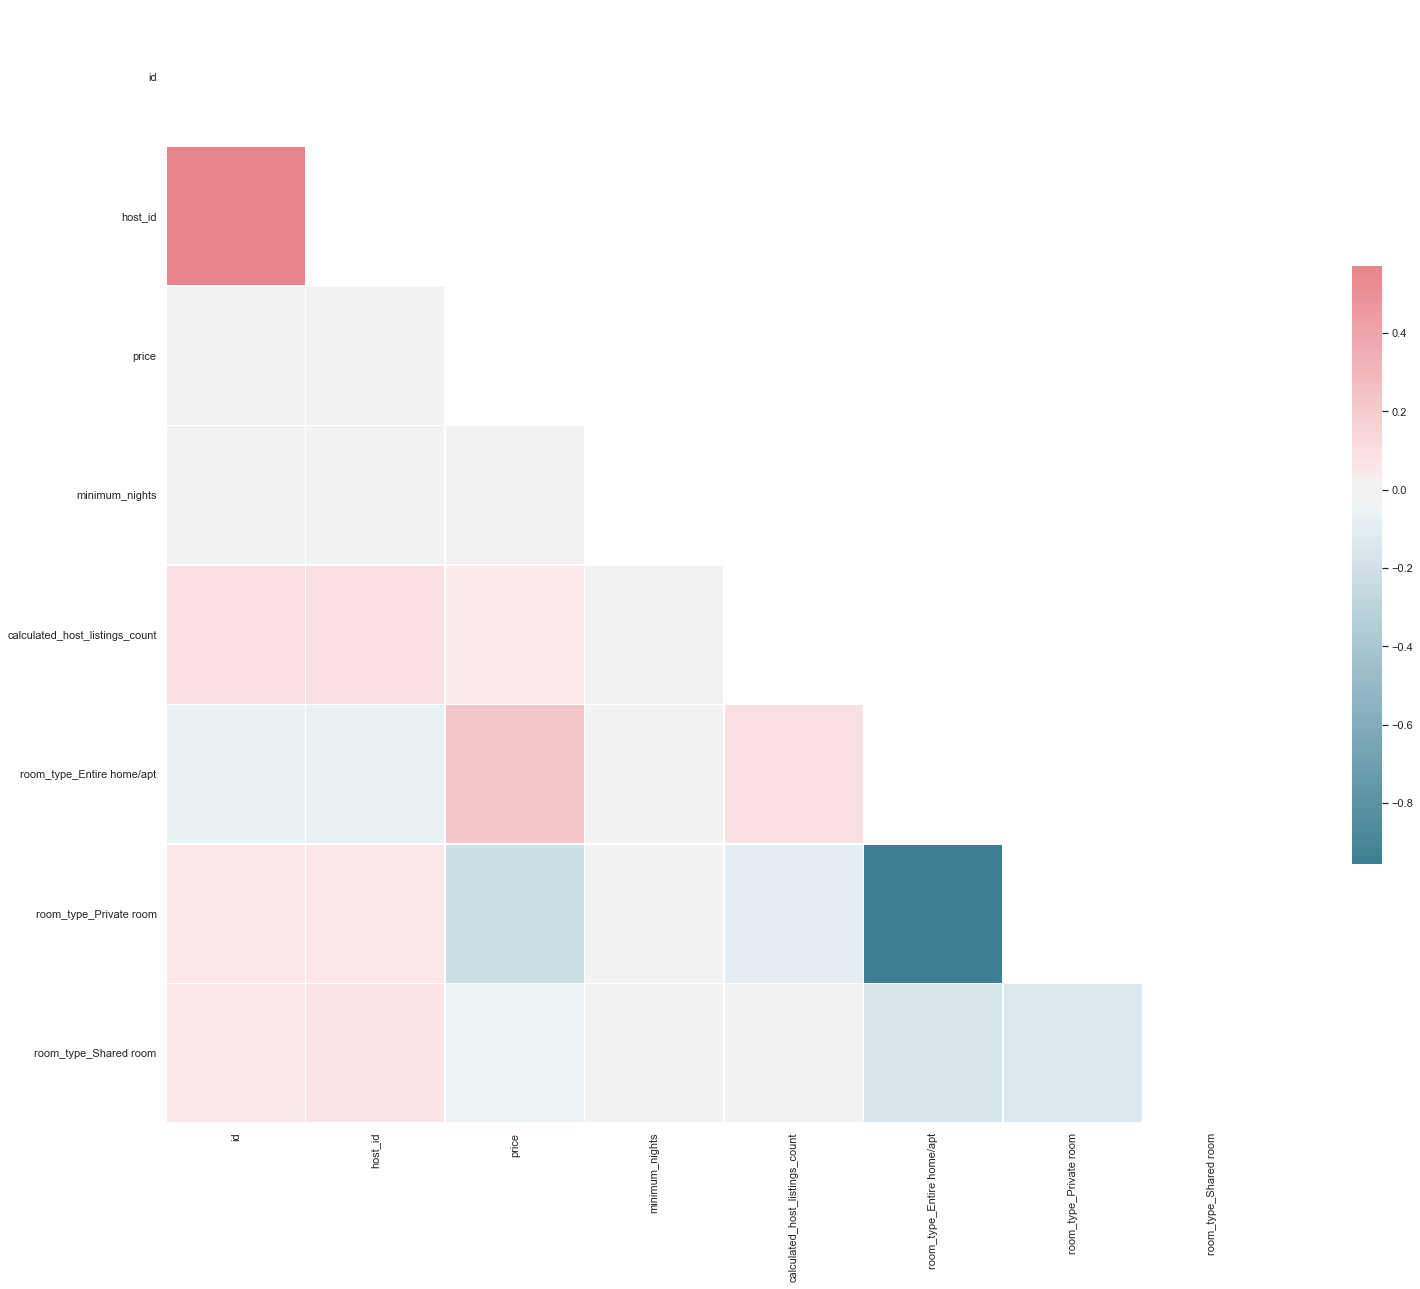

In [52]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

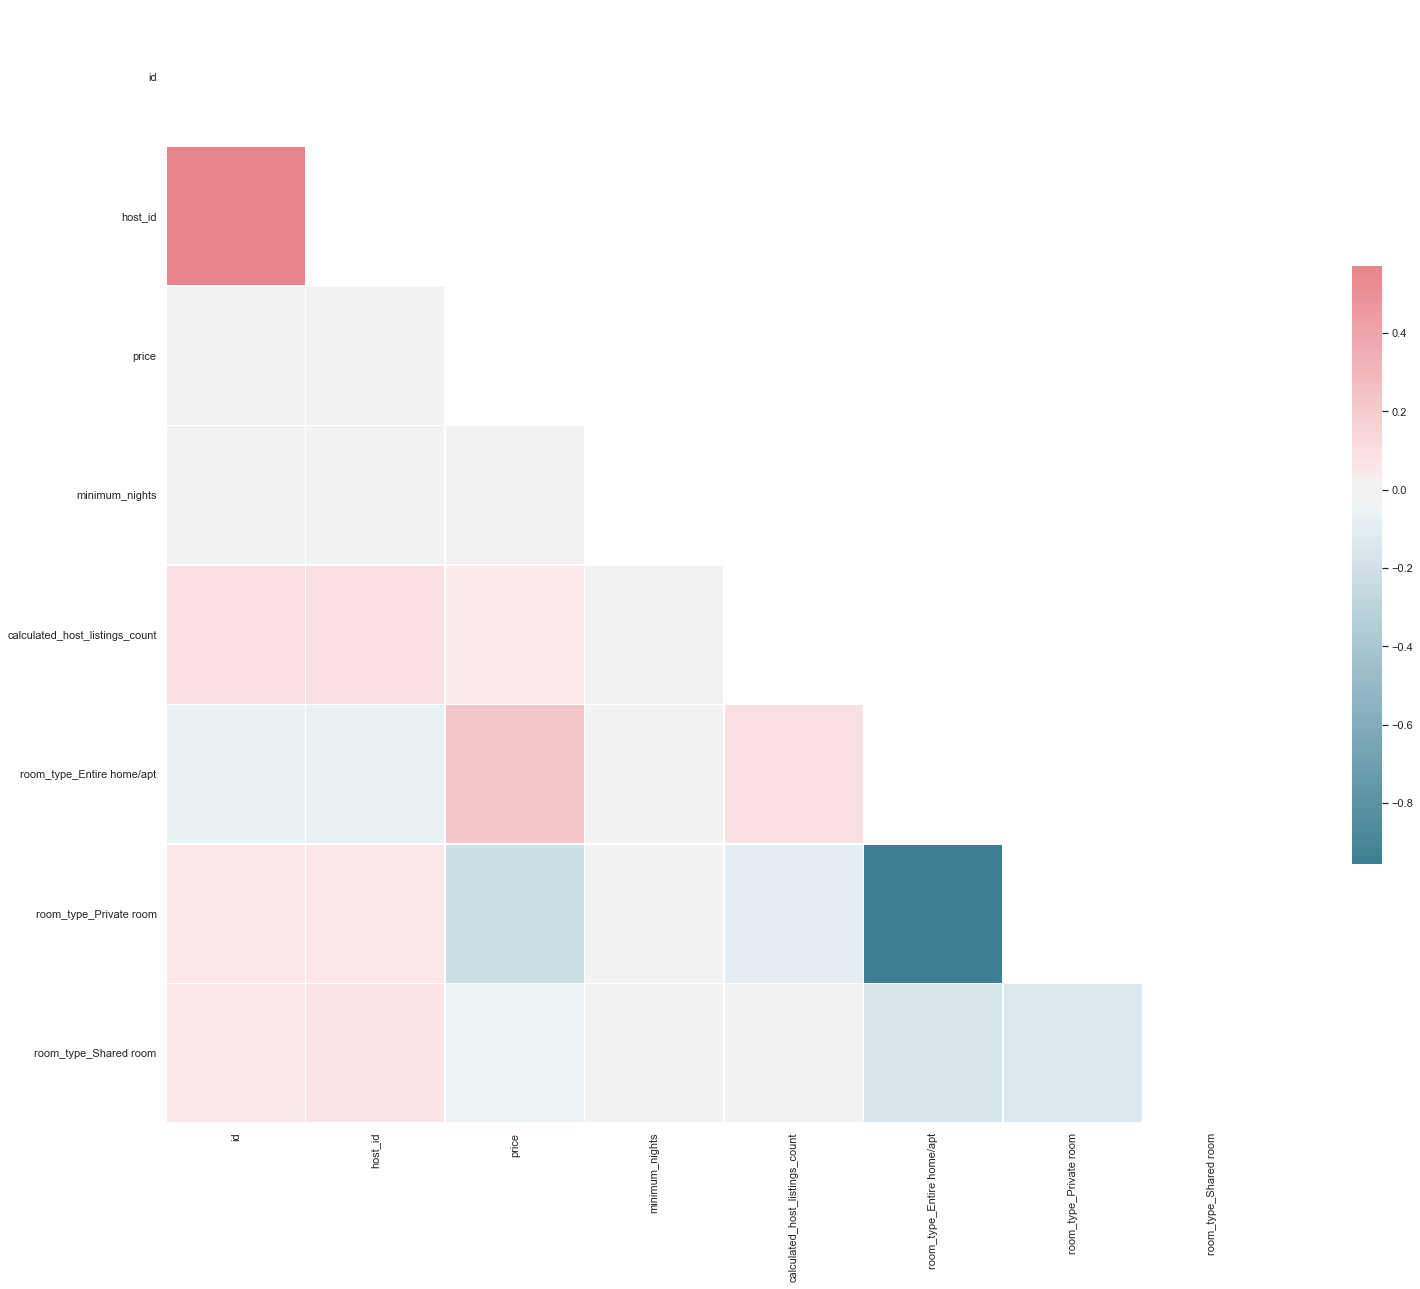

In [54]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

In [56]:
numerical_columns = ['price', 'id', 'calculated_host_listings_count', 'minimum_nights']


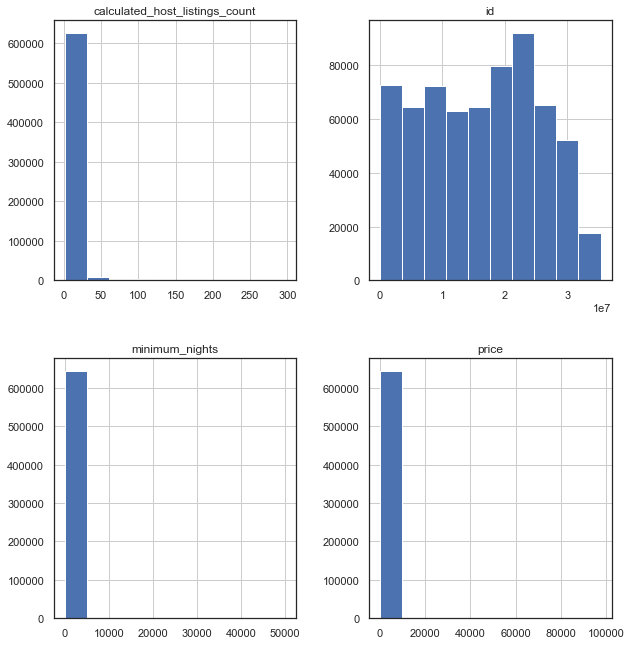

In [57]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [64]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

TypeError: invalid type promotion

In [65]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [66]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields date

In [67]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

AttributeError: Feature importance is not defined for Booster type None

In [68]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

NameError: name 'ft_weights_xgb_reg' is not defined

<Figure size 576x1440 with 0 Axes>

In [71]:
print("Median number of listings per host:", int(raw_df.calculated_host_listings_count.median()))
print("Mean number of listings per host:", int(round(raw_df.calculated_host_listings_count.mean())))
print(f"{int(round(100*len(raw_df[raw_df.calculated_host_listings_count == 1])/len(raw_df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 5
67% of listings are from hosts with one listing.


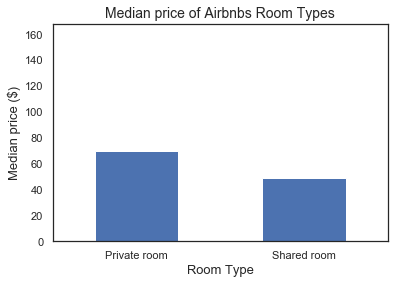

In [73]:
raw_df.groupby('room_type').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs Room Types', fontsize=14)
plt.xlabel('Room Type', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

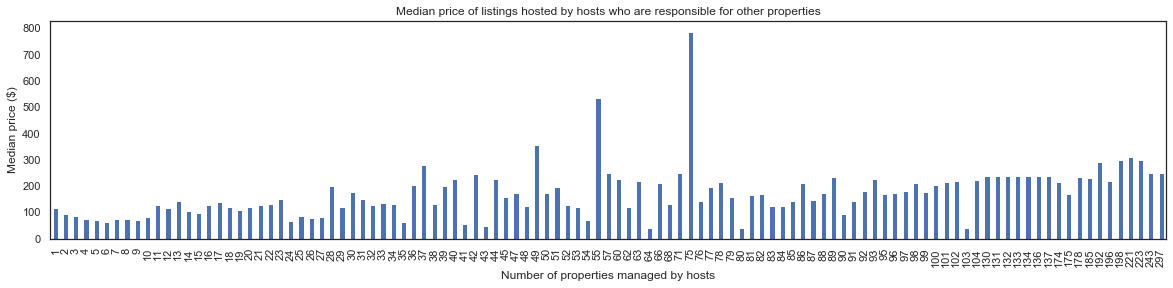

In [70]:
# Median price for different host listing counts
plt.figure()
raw_df.groupby('calculated_host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price ($)');

In [74]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               30464     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 129,537
Trainable params: 129,537
Non-trainable params: 0
_________________________________________________________________
None
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


AttributeError: 'NoneType' object has no attribute 'create'

In [75]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [78]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

In [79]:
nn_model_evaluation(nn2)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [80]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
SVG(model_to_dot(nn3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               30464     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 261,377
Trainable params: 261,377
Non-trainable params: 0
_________________________________________________________________
None
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


AttributeError: 'NoneType' object has no attribute 'create'

In [81]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [82]:
# Evaluating the model
nn_model_evaluation(nn3, skip_epochs=2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [83]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())

# Visualising the neural network
SVG(model_to_dot(nn4, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               30464     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 261,377
Trainable params: 261,377
Non-trainable params: 0
_________________________________________________________________
None
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


AttributeError: 'NoneType' object has no attribute 'create'

In [84]:
# Training the model
nn4_start = time.time()

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn4_end = time.time()

print(f"Time taken to run: {round((nn4_end - nn4_start)/60,1)} minutes")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [85]:
nn_model_evaluation(nn4, skip_epochs=10) # This model took several epochs before the loss was in a similar range to other models

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [86]:
nn5 = models.Sequential()
nn5.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
nn5.add(layers.Dense(128, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(256, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(512, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn5.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn5.summary())

# Visualising the neural network
SVG(model_to_dot(nn5, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 237)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               30464     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

AttributeError: 'NoneType' object has no attribute 'create'

In [87]:
# Training the model
nn5_start = time.time()

nn5_history = nn5.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=256,
                  validation_split = 0.1)

nn5_end = time.time()

print(f"Time taken to run: {round((nn5_end - nn5_start)/60,1)} minutes")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [88]:
nn_model_evaluation(nn5, skip_epochs=2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [89]:
nn6 = models.Sequential()
nn6.add(layers.Dropout(0.2, input_shape=(X_train.shape[1],)))
nn6.add(layers.Dense(128, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(256, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(512, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn6.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn6.summary())

# Visualising the neural network
SVG(model_to_dot(nn6, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 237)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               30464     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

AttributeError: 'NoneType' object has no attribute 'create'

In [90]:
# Training the model
nn6_start = time.time()

nn6_history = nn6.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=512,
                  validation_split = 0.1)

nn6_end = time.time()

print(f"Time taken to run: {round((nn6_end - nn6_start)/60,1)} minutes")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [91]:
nn_model_evaluation(nn6)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).